In [1]:
%%capture
!pip install PyDrive
!pip install gensim
!pip install pyldavis
!python -m spacy download en
!pip install nltk
!pip install wordcloud
!pip install bertopic

In [6]:
!pip install seaborn

     -------------------------------------- 288.2/288.2 kB 8.7 MB/s eta 0:00:00


In [2]:
# from google.colab import drive
# #drive.mount('/drive')  # Add My Drive/<>

# import os
# #os.chdir("/drive/My Drive/NLPProject")
# drive.mount('/content/drive')
# os.chdir("drive/My Drive/NLP")
#os.chdir("Project")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import nltk
from nltk import FreqDist
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\coder\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import json
import re
import gzip
import warnings
warnings.filterwarnings("ignore")

import gensim
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

c:\Users\coder\anaconda3\envs\NLP\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [3]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    name=b'"verified": \"true\",'
    l=l.replace(b'"verified": true,',bytes(name))
    name1=b'"verified": \"false\",'
    l=l.replace(b'"verified": false,',bytes(name))
    yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [4]:
df1 = getDF('AMAZON_FASHION.json.gz')
df1.shape

(883636, 12)

In [5]:
df2 = getDF('meta_AMAZON_FASHION.json.gz')
df2.shape

(186637, 16)

In [6]:
df1.head(2)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,true,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2.0,true,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...","I agree with the other review, the opening is ...",1411862400,3,NaN,NaN


In [7]:
df1['asin'].value_counts()

B000V0IBDM    4384
B000KPIHQ4    4375
B00I0VHS10    3889
B00RLSCLJM    3638
B000PHANNM    2572
              ... 
B00VQHSOE0       1
B00VQH61O0       1
B00VQGEHII       1
B00VQGZT76       1
B01HJG5NMW       1
Name: asin, Length: 186189, dtype: int64

In [8]:
df1.dropna(subset=['reviewText'],inplace=True)

In [9]:
df=df1[df1.overall>4.0].reset_index()

In [10]:
thresh_50Percent = len(df)/2
df1.dropna(thresh=thresh_50Percent, axis=1, inplace=True)

In [11]:
df.shape

(464591, 13)

In [12]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

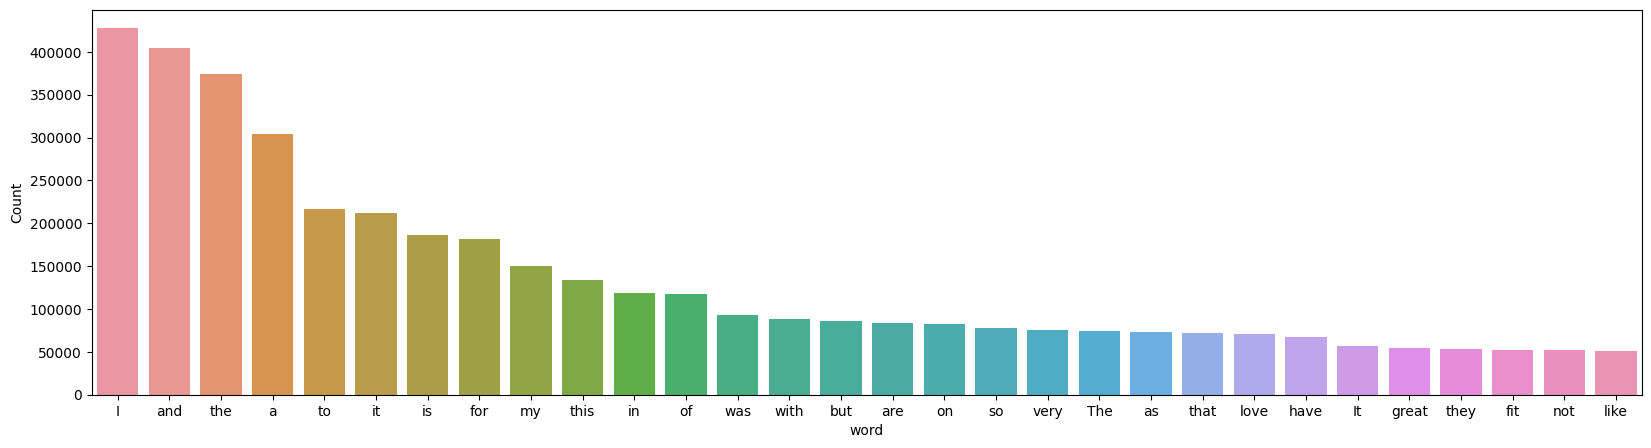

In [13]:
freq_words(df['reviewText'])

In [14]:
# function to remove stopwords
def remove_stopwords(rev):
  rev_new = " ".join([i for i in rev if i not in stop_words])
  return rev_new

In [15]:
#remove stop words
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
add_stop_words = ['good', 'great', 'perfect','love','like','would','nice','beautiful',\
                  'excellent','loved','thank','recieved','fast','exactly','expected','really','got',\
                  'product','perfectly','honest','also','review','super']
stop_words = stop_words.union(add_stop_words)

def stopText(text_array):
    h2 = ""
    for h in text_array:
        if h.lower() not in stop_words:
          h2 = h2 + ' ' + h
    return h2


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\coder\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\coder\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
import string
# Remove punctuations
def removePuncStr(s):
    for c in string.punctuation:
        s = s.replace(c," ")
    return s

def removePunc(text_array):
    return [removePuncStr(h) for h in text_array]

# Remove numbers
def removeNumbersStr(s):
  for c in range(10):
    n = str(c)
    s = s.replace(n,"")
  return s

def removeNumbers(text_array):
    return [removeNumbersStr(h) for h in text_array]

In [17]:
df['reviewText'] = df['reviewText'].apply(lambda x: removePuncStr(x))
df['reviewText'] = df['reviewText'].apply(lambda x: removeNumbersStr(x))
df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
df['reviewText'] = df['reviewText'].apply(lambda x: str(x).lower())
df['reviewText'] = df['reviewText'].apply(lambda x: stopText(x.split()))

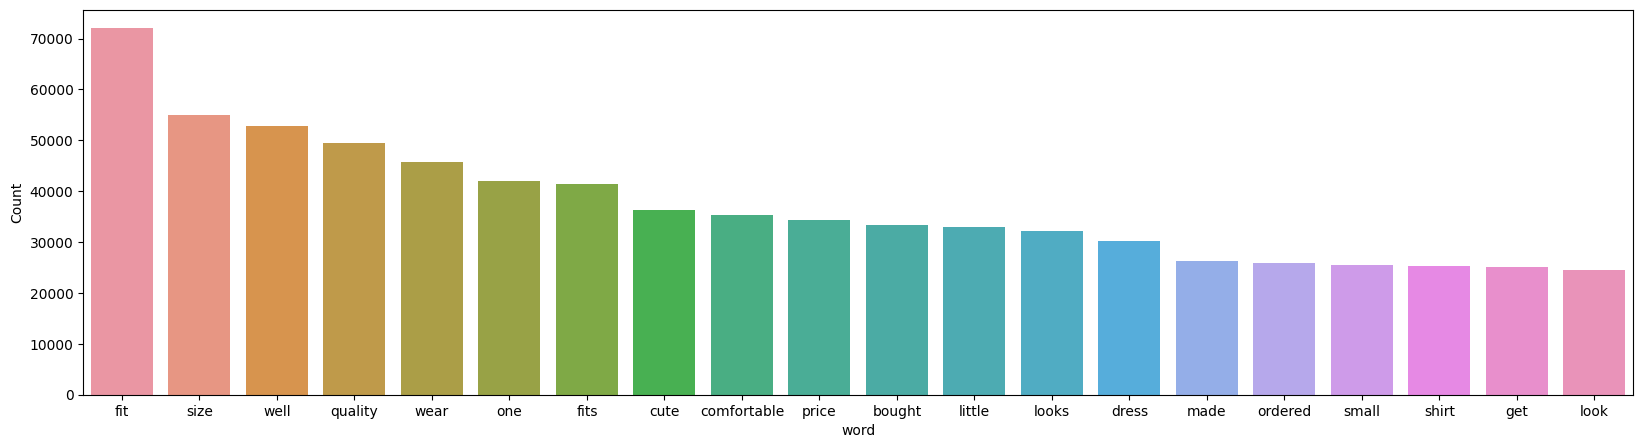

In [18]:
freq_words(df['reviewText'], 20)

In [19]:
# Stemming
nltk.download('punkt')
from nltk.stem import PorterStemmer
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\coder\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\coder\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\coder\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [20]:
def stemText(text):
    words = word_tokenize(text)
    stemmed_text = ''
    for w in words:
        stemmed_text = stemmed_text + ' ' + PorterStemmer().stem(w)
    return stemmed_text

In [21]:
def lemmText(text):
    WNlemmatizer = WordNetLemmatizer()
    lemmatized_text = ''

    words = word_tokenize(text) 
    for w in words:
        lemmatized_text = lemmatized_text + ' ' + WNlemmatizer.lemmatize(w)
    return lemmatized_text


In [22]:
# df['reviewText'] = df['reviewText'].apply(lambda x: stemText(x))
df['reviewText'] = df['reviewText'].apply(lambda x: lemmText(x))

In [23]:
reviewText = " ".join(review for review in df['reviewText'])

c:\Users\coder\anaconda3\envs\NLP\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Users\coder\anaconda3\envs\NLP\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
c:\Users\coder\anaconda3\envs\NLP\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Users\coder\anaconda3\envs\NLP\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_s

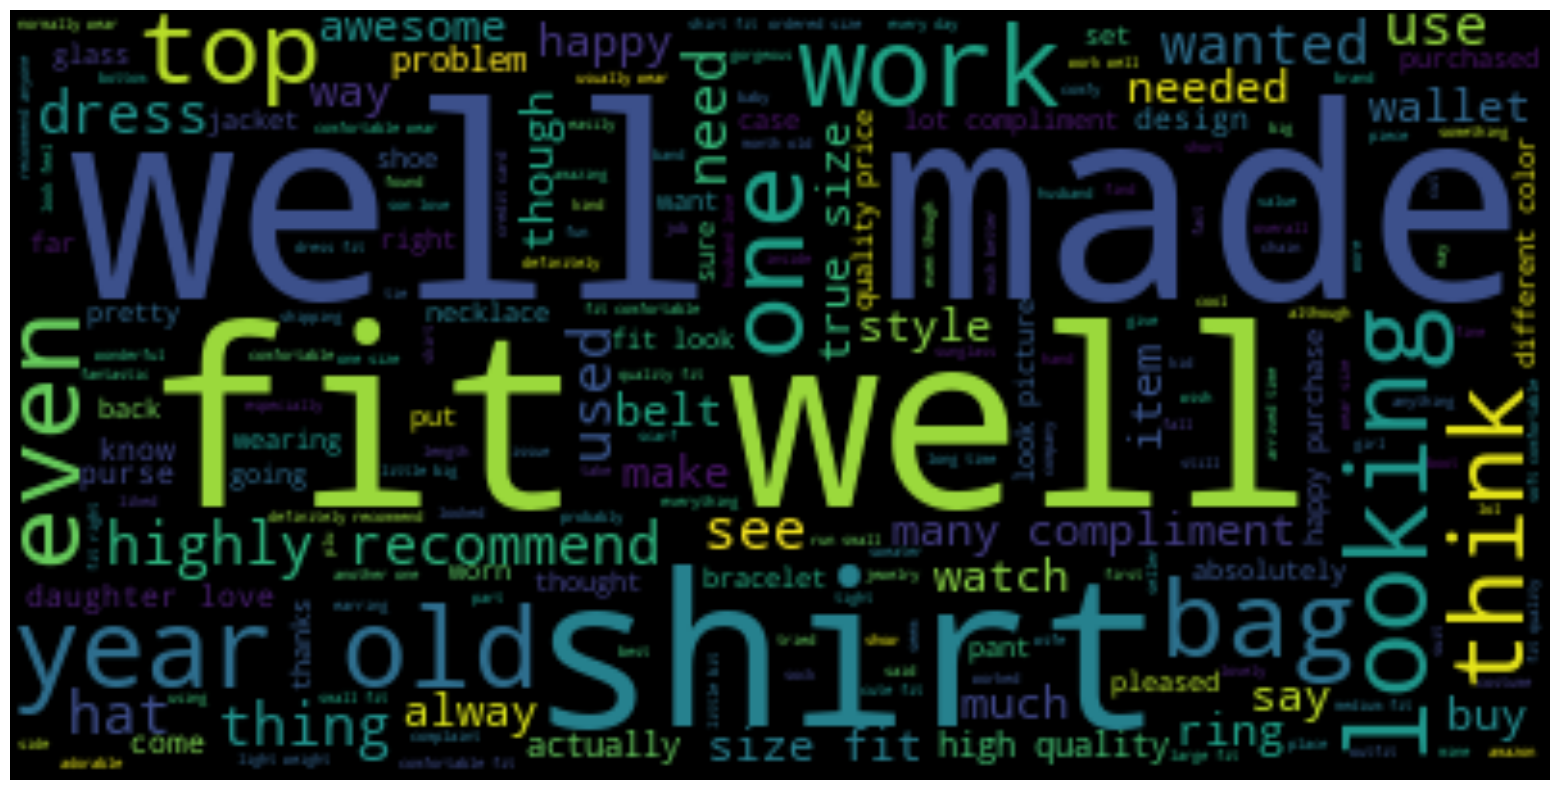

In [24]:
from wordcloud import WordCloud
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(reviewText)

# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
df_test = df[:100000]

In [26]:
df_test

,index,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,0,5.0,true,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,needed,perfect replacements!!,1413763200,NaN,NaN,NaN
1,5,5.0,true,"07 19, 2014",A29HLOUW0NS0EH,7106116521,Patricia R. Erwin,wanted,Five Stars,1405728000,NaN,NaN,NaN
2,16,5.0,true,"10 24, 2017",A1NSKPSR0XZ0C9,B00007GDFV,Jules,looking,Perfect just what I was looking for!,1508803200,NaN,{'Color:': ' Black'},NaN
3,17,5.0,true,"10 13, 2017",A3O5SXH5O8DWRP,B00007GDFV,Debra Humphreys,quality happy purchase,I am very happy with my purchase,1507852800,NaN,{'Color:': ' Black'},NaN
4,20,5.0,true,"09 17, 2017",A1L5PG0YZ4TNSZ,B00007GDFV,karen puckett,,Five Stars,1505606400,NaN,{'Color:': ' Black'},NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,173780,5.0,true,"02 21, 2015",A2QC0PMVQ7VDZD,B00IKG2ILK,janet,already wore one piece form fitting see know people keep saying even wear bra cute tall probably fit tall fit,Perfect for summer!,1424476800,NaN,NaN,NaN
99996,173786,5.0,true,"01 31, 2015",A2PPL2AYN2XO8R,B00IKG2ILK,Sarah,lovely,Five Stars,1422662400,NaN,NaN,NaN
99997,173788,5.0,true,"01 26, 2015",AB08RUSNR5D78,B00IKG2ILK,Summer,,Five Stars,1422230400,NaN,NaN,NaN
99998,173789,5.0,true,"01 2, 2015",ALTYUZISXZUPT,B00IKG2ILK,Victoria.Heart,form fitting flattering curvy figure material fit,Would buy again!,1420156800,NaN,NaN,NaN


In [ ]:
# Topic model
from bertopic import BERTopic
# Dimension reduction
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN
# Initiate UMAP
umap_model = UMAP(n_neighbors=15, 
                  n_components=5, 
                  min_dist=0.0, 
                  metric='cosine', 
                  random_state=100)
from sentence_transformers import SentenceTransformer

sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(df_test['reviewText'], show_progress_bar=False)
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english", min_df=10)

# Initiate BERTopic
topic_model = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=False, low_memory=True,vectorizer_model=vectorizer_model,  embedding_model=sentence_model)
# Run BERTopic model
topics, probabilities = topic_model.fit_transform(df_test['reviewText'], embeddings)

In [ ]:
from sklearn.metrics import silhouette_score
# Generate `X` and `labels` only for non-outlier topics (as they are technically not clusters)
umap_embeddings = topic_model.umap_model.transform(embeddings)
indices = [index for index, topic in enumerate(topics) if topic != -1]
X = umap_embeddings[np.array(indices)]
labels = [topic for index, topic in enumerate(topics) if topic != -1]

# Calculate silhouette score
silhouette_score(X, labels)

In [ ]:
# Get the list of topics
topic_model.get_topic_info()[1:21]

,Topic,Count,Name
0,-1,3374,-1_support_foot_shoe_arch
1,0,10,0_powerstep pinnacle_insole year_powerstep_pinnacle
2,1,10,1____
3,2,10,2_fit___
4,3,10,3_fine_fit_pretty_worked
...,...,...,...
133,132,5,132_hour_hour day_hurt_try
134,133,5,133_fit shoe_provide support_shoe insole_amazing
135,134,5,134_couple_away_pain free_pain
136,135,5,135_foot problem_foot issue_problem_insole year


In [69]:
# Get top 10 terms for a topic
topic_model.get_topic(0)

[('hurt', 0.03233627343221891),
 ('foot', 0.023568236113221126),
 ('pain', 0.022944390595728496),
 ('day', 0.022502819342796163),
 ('bit', 0.019059770891714876),
 ('week', 0.018207024976253684),
 ('little', 0.017659066278059743),
 ('work', 0.017213290978773253),
 ('knee', 0.016827010719685166),
 ('hour', 0.016289575730274005)]

In [70]:
# Visualize top topic keywords
topic_model.visualize_barchart(top_n_topics=20,n_words=8, width=400)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.017213290978773253, 0.017659066278059743,
                    0.018207024976253684, 0.019059770891714876,
                    0.022502819342796163, 0.022944390595728496,
                    0.023568236113221126, 0.03233627343221891],
              'xaxis': 'x',
              'y': [work  , little  , week  , bit  , day  , pain  , foot  , hurt
                    ],
              'yaxis': 'y'},
             {'marker': {'color': '#0072B2'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.03642240228660681, 0.04153412388599652,
                    0.043689713615305194, 0.04804702398819499, 0.05432493936612778,
                    0.072155233190416, 0.16202594718349397, 0.30112475250036186],
              'xaxis': 'x2',
              'y': [tried  , little  , custom  , purchased  , hurt  , going  ,
                    insert  , best  ],
              'yaxis': 'y2'},
             {'marker': {'color': '#CC79A7'},
              'orientation': 'h',
              'type': 'bar',
              'x': [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05,
                    2.2321626286975],
              'xaxis': 'x3',
              'y': [  ,   ,   ,   ,   ,   ,   , wonderful  ],
              'yaxis': 'y3'},
             {'marker': {'color': '#E69F00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.024281601524404537, 0.026510524960322333,
                    0.028229509477835976, 0.02999812258627955, 0.03092654612519595,
                    0.033169053657575644, 0.03450663687911774,
                    0.046685289404194634],
              'xaxis': 'x4',
              'y': [tried  , bad  , foot  , walk  , work  , month  , time  , foot
                    pain  ],
              'yaxis': 'y4'},
             {'marker': {'color': '#56B4E9'},
              'orientation': 'h',
              'type': 'bar',
              'x': [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05,
                    0.6109090823229731],
              'xaxis': 'x5',
              'y': [  ,   ,   ,   ,   ,   ,   , comfortable  ],
              'yaxis': 'y5'},
             {'marker': {'color': '#009E73'},
              'orientation': 'h',
              'type': 'bar',
              'x': [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 0.2880428507372258,
                    0.2880428507372258, 0.29523009714181264],
              'xaxis': 'x6',
              'y': [  ,   ,   ,   ,   , buy  , size  , price  ],
              'yaxis': 'y6'},
             {'marker': {'color': '#F0E442'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.018562023129031106, 0.018771267333240433,
                    0.02068638563856349, 0.02205449370436378, 0.023753055152895195,
                    0.024159885080711457, 0.025779902599842957, 0.0327266681852963],
              'xaxis': 'x7',
              'y': [second  , day  , highly recommend  , set  , plantar  ,
                    fasciitis  , plantar fasciitis  , powerstep  ],
              'yaxis': 'y7'},
             {'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.029169811640606558, 0.029857860944192505,
                    0.03820579625030588, 0.05000482457482712, 0.05303907105184455,
                    0.059606876638236134, 0.06141720718011712, 0.11476551532633697],
              'xaxis': 'x8',
              'y': [helped  , help  , walking  , pain  , arch  , spur  , sore  ,
                    heel  ],
              'yaxis': 'y8'},
             {'marker': {'color': '#0072B2'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.031388922533374566, 0.032145958678238995,
                    0.03420810903357541, 0.035503425448127256, 0.05001995293306568,
                    0.05959363886082633, 0.082939227905606

In [71]:
tokenized_reviews = df['reviewText'].apply(lambda x: x.split())
print(tokenized_reviews[1])

KeyError: 1

In [72]:
import gensim
from gensim import corpora

In [73]:
doc_clean = [doc.split() for doc in df_test['reviewText']]
dictionary = corpora.Dictionary(doc_clean)

In [74]:
#Unique words in the dictionary
len(set(dictionary))

4323

In [75]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [76]:
#check few properties of the matrix
print(len(doc_term_matrix))
print(type(doc_term_matrix))
print(len(doc_term_matrix[0]))
print(len(doc_term_matrix[1]))

4380
<class 'list'>
5
2


In [77]:
%%time 
#RUN THE MODEL
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=10, 
                random_state=100,
                chunksize=10000,
                passes=10)

CPU times: total: 22.4 s
Wall time: 22.4 s


In [78]:
lda_model.print_topics()

[(0,
  '0.039*"shoe" + 0.036*"insert" + 0.034*"year" + 0.022*"foot" + 0.018*"doctor" + 0.016*"recommended" + 0.016*"pair" + 0.015*"used" + 0.012*"using" + 0.012*"lot"'),
 (1,
  '0.057*"shoe" + 0.034*"support" + 0.033*"arch" + 0.032*"insole" + 0.029*"foot" + 0.014*"fit" + 0.010*"work" + 0.008*"insert" + 0.008*"comfortable" + 0.008*"high"'),
 (2,
  '0.034*"work" + 0.029*"shoe" + 0.026*"orthotics" + 0.023*"well" + 0.017*"custom" + 0.015*"year" + 0.013*"foot" + 0.013*"brand" + 0.013*"far" + 0.012*"fit"'),
 (3,
  '0.036*"pain" + 0.027*"foot" + 0.024*"comfortable" + 0.019*"shoe" + 0.017*"heel" + 0.014*"work" + 0.014*"day" + 0.013*"walking" + 0.013*"well" + 0.012*"fit"'),
 (4,
  '0.029*"best" + 0.028*"foot" + 0.021*"insole" + 0.017*"buy" + 0.016*"difference" + 0.014*"year" + 0.012*"without" + 0.012*"ever" + 0.011*"make" + 0.011*"used"'),
 (5,
  '0.031*"shoe" + 0.023*"insole" + 0.018*"pair" + 0.018*"foot" + 0.016*"time" + 0.016*"use" + 0.015*"year" + 0.014*"day" + 0.013*"last" + 0.011*"bought"

In [82]:
# Visualize the 
#read: https://community.alteryx.com/t5/Data-Science/Getting-to-the-Point-with-Topic-Modeling-Part-3-Interpreting-the/ba-p/614992#:~:text=The%20intertopic%20distance%20map%20is,each%20topic%20across%20the%20dictionary.
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.034754 -0.017544       1        1  26.586728
1     -0.059573  0.056848       2        1  22.731938
8     -0.068126  0.032219       3        1   9.463527
3     -0.052222 -0.022637       4        1   7.843891
2     -0.013573  0.017813       5        1   7.547845
5      0.017393 -0.032202       6        1   6.963672
0     -0.031134 -0.044723       7        1   6.400895
7     -0.002670  0.103151       8        1   5.493955
9      0.196388  0.053743       9        1   3.550134
4      0.048271 -0.146668      10        1   3.417415, topic_info=          Term        Freq       Total Category  logprob  loglift
61         fit  693.000000  693.000000  Default  30.0000  30.0000
17        pair  853.000000  853.000000  Default  29.0000  29.0000
25       price  266.000000  266.000000  Default  28.0000  28.0000
16        pain  916.000000  916.000000  Default  27.0000  27.0000
92        year  535.000000  535.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
53        week   11.042734  202.799660  Topic10  -5.3020   0.4658
230      worth   10.375782  100.846107  Topic10  -5.3643   1.1022
16        pain   11.718118  916.825205  Topic10  -5.2426  -0.9835
201    walking   10.894865  266.967452  Topic10  -5.3154   0.1775
59   fasciitis   11.034657  484.867116  Topic10  -5.3027  -0.4065

[814 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1660      6  0.278514        abeo
1660     10  0.557028        abeo
871       2  0.213591      accept
871       5  0.427182      accept
2930      5  0.811639  acceptable
...     ...       ...         ...
92        6  0.126928        year
92        7  0.266923        year
92        8  0.011200        year
92        9  0.013066        year
92       10  0.055998        year

[2235 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 9, 4, 3, 6, 1, 8, 10, 5])

Positively rated Topics:\
1: Shoes \
2: Clothes\
3: Jewllery\
4: Bags

In [77]:
# Print the Keyword in the 10 topics
lda_model.print_topics()

[(0,
  '0.058*"boot" + 0.022*"shirt" + 0.016*"jacket" + 0.016*"leather" + 0.011*"toe" + 0.009*"stretcher" + 0.008*"one" + 0.008*"get" + 0.007*"liner" + 0.007*"quality"'),
 (1,
  '0.031*"pair" + 0.024*"ring" + 0.021*"one" + 0.020*"wear" + 0.017*"year" + 0.016*"flip" + 0.015*"flop" + 0.011*"comfortable" + 0.011*"get" + 0.010*"time"'),
 (2,
  '0.039*"foot" + 0.039*"shoe" + 0.028*"support" + 0.024*"arch" + 0.021*"insole" + 0.013*"best" + 0.013*"sock" + 0.012*"day" + 0.012*"pair" + 0.011*"comfortable"'),
 (3,
  '0.036*"well" + 0.021*"fit" + 0.020*"costume" + 0.017*"made" + 0.015*"cute" + 0.015*"color" + 0.014*"bought" + 0.010*"look" + 0.010*"one" + 0.009*"wear"'),
 (4,
  '0.060*"hat" + 0.026*"sun" + 0.025*"fit" + 0.023*"head" + 0.015*"one" + 0.013*"protection" + 0.013*"well" + 0.012*"light" + 0.012*"stay" + 0.011*"face"'),
 (5,
  '0.067*"fit" + 0.037*"size" + 0.025*"comfortable" + 0.024*"pant" + 0.020*"belt" + 0.019*"pocket" + 0.013*"small" + 0.013*"look" + 0.013*"little" + 0.012*"quality"'